In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Whole DATA

## Clean txt files, concatenate and read them to dataframe

In [3]:
for x in range(2013,2021):
    f = open(f"nov{x}-{x+1}.txt", "r")
    content = f.read()
    f.close()

    content = content.replace(" ","")

    g = open(f"nov{x}-{x+1}.txt", "w")
    g.write(content)
    g.close()

In [4]:
frames = []

for x in range(2013,2021):
    frames.append(pd.read_csv(f"nov{x}-{x+1}.txt", sep = ","))

data = pd.concat(frames)

In [5]:
data = data.rename(columns = {'&Otilde;hur&otilde;hk':'Õhurõhk'})

## Cleansing

In [6]:
def repair_timestamp(data):
    data["Aeg"] = data.apply(lambda row: datetime.strptime(row["Aeg"],"%Y-%m-%d%H:%M:%S"), axis=1)

In [7]:
repair_timestamp(data)

In [8]:
data.dtypes

Aeg               datetime64[ns]
Temperatuur              float64
Niiskus                  float64
Õhurõhk                  float64
Tuulekiirus              float64
Tuulesuund               float64
Sademed                  float64
UVindeks                 float64
Valgustatus              float64
Kiirgusvoog              float64
Radioaktiivsus           float64
dtype: object

In [9]:
data = data[["Aeg","Temperatuur","Niiskus","Õhurõhk","Tuulekiirus","Tuulesuund","Sademed","Kiirgusvoog"]]

data['Sademed'] = data['Sademed'].fillna(0)
data['Tuulekiirus'] = data['Tuulekiirus'].fillna(method='backfill')
data['Tuulesuund'] = data['Tuulesuund'].fillna(method='backfill')
data['Temperatuur'] = data['Temperatuur'].fillna(method='backfill')
data['Niiskus'] = data['Niiskus'].fillna(method='backfill')
data['Õhurõhk'] = data['Õhurõhk'].fillna(method='backfill')
data['Kiirgusvoog'] = data['Kiirgusvoog'].fillna(method='backfill')
data["KiirgusvoogTulevikus"] = data["Kiirgusvoog"].shift(-1)
data = data.dropna()
data.isnull().sum()

Aeg                     0
Temperatuur             0
Niiskus                 0
Õhurõhk                 0
Tuulekiirus             0
Tuulesuund              0
Sademed                 0
Kiirgusvoog             0
KiirgusvoogTulevikus    0
dtype: int64

In [10]:
data = data.rename(columns = {
    'Aeg': 'timestamp',
    'Temperatuur':'temperature',
    'Niiskus':'humidity',
    'Õhurõhk':'atmospheric_pressure',
    'Tuulekiirus':'wind_speed',
    'Tuulesuund':'wind_direction',
    'Sademed':'precipitation',
    #'Sadanudlumi':'snow',
    'Kiirgusvoog':'radiation_flux',
    'KiirgusvoogTulevikus':'rad_flux_infuture'    
    })
data.columns

Index(['timestamp', 'temperature', 'humidity', 'atmospheric_pressure',
       'wind_speed', 'wind_direction', 'precipitation', 'radiation_flux',
       'rad_flux_infuture'],
      dtype='object')

In [11]:
data.describe()

,temperature,humidity,atmospheric_pressure,wind_speed,wind_direction,precipitation,radiation_flux,rad_flux_infuture
count,811085.000000,811085.000000,811085.000000,811085.000000,811085.000000,811085.000000,811085.000000,811085.000000
mean,6.825025,75.458473,1010.824081,3.258511,199.267411,0.004576,89.464947,89.464947
std,8.905742,19.869568,11.040802,1.678265,91.412932,0.050455,181.339887,181.339887
min,-24.307660,0.000000,963.557524,0.000000,0.000000,0.000000,-2.625525,-2.625525
25%,0.635374,62.394290,1003.885773,2.053779,124.554193,0.000000,0.000000,0.000000
50%,5.843931,81.315327,1011.116467,3.025117,224.132079,0.000000,2.639460,2.639460
75%,13.633509,91.499743,1018.149000,4.240506,274.416061,0.000000,74.003317,74.003317
max,33.553939,117.297204,1045.714767,15.497177,360.000000,9.799000,1132.409778,1132.409778


In [12]:
data.sample(5)

,timestamp,temperature,humidity,atmospheric_pressure,wind_speed,wind_direction,precipitation,radiation_flux,rad_flux_infuture
38198,2014-03-27 15:55:00,10.495461,1.815235,1015.089723,3.493323,31.397019,0.0,0.000000,0.000000
11299,2017-12-24 05:35:00,1.143612,67.718081,984.374333,7.498888,300.774215,0.0,2.181622,2.150262
36670,2014-03-22 08:35:00,5.775338,56.652363,994.065698,2.781791,244.216785,0.0,0.000000,0.000000
102956,2017-11-07 11:25:00,6.602788,77.857366,1026.091433,4.207248,273.217437,0.0,275.020651,308.095015
82378,2021-08-19 16:05:00,17.092005,77.800577,999.906000,3.879417,230.948439,0.0,495.758953,464.955255


In [13]:
#current_timestamp = str(round(datetime.datetime.now().timestamp()))
#print(current_timestamp)
#data.to_csv(f"data{current_timestamp}.csv",index=False)

## Timeseries

In [14]:
def parser(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

In [15]:
series_rad = data[["timestamp","radiation_flux"]]
series_rad.to_csv("series_rad.csv",index=False)
series_rad = pd.read_csv("series_rad.csv",header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series_rad.index = series_rad.index.to_period('T')
series_rad.sample(5)

timestamp
2020-11-06 17:25      0.000000
2020-10-07 16:05    218.223813
2017-05-31 15:30     84.403976
2021-03-27 04:50      5.326073
2019-10-24 10:50     52.516804
Freq: T, Name: radiation_flux, dtype: float64

In [16]:
series_rad.index.max()

Period('2021-11-14 23:50', 'T')

In [17]:
def filter_time(series,min_time):
    return series[series.index>=min_time]

In [18]:
series_rad_selection = filter_time(series_rad,"2021-11-01 00:00")

In [19]:
print("max: ",series_rad_selection.values.max())
print("min: ",series_rad_selection.values.min())

max:  349.008903987
min:  0.0


# ARIMA

## About

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## Autocorrelation

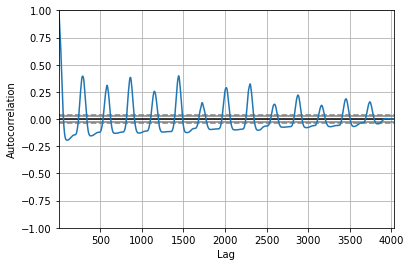

In [50]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series_rad_selection)
plt.show()

We can see here negative autocorrelation?

## Train and predict

In [51]:
# fit model
model = ARIMA(series_rad_selection, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         radiation_flux   No. Observations:                 4031
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13763.999
Date:                Thu, 02 Dec 2021   AIC                          27539.998
Time:                        14:42:39   BIC                          27577.807
Sample:                    11-01-2021   HQIC                         27553.395
                         - 11-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2245      0.005     47.792      0.000       0.215       0.234
ar.L2         -0.1643      0.005    -33.352      0.000      -0.174      -0.155
ar.L3          0.0597      0.006     10.122      0.0

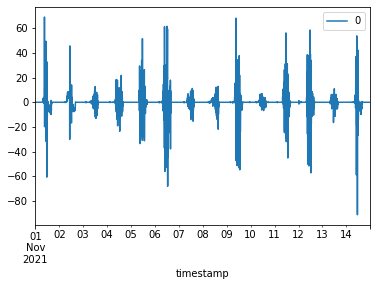

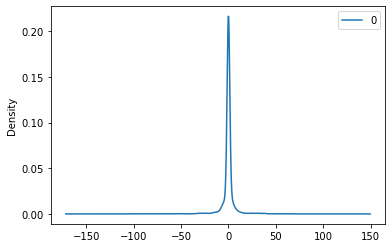

                   0
count   4.031000e+03
mean    7.699380e-17
std     7.362751e+00
min    -9.126291e+01
25%    -1.479426e-37
50%    1.976263e-323
75%     1.671301e-35
max     6.917988e+01


In [52]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Evaluate an ARIMA model using a walk-forward validation

In [55]:
# split into train and test sets
X = series_rad_selection.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [56]:
print("values X: ",X.shape,type(X))
print("train: ",train.shape,type(train))
print("test: ",test.shape,type(test))
print("history: ",len(history),type(history))

values X:  (4031,) <class 'numpy.ndarray'>
train:  (3627,) <class 'numpy.ndarray'>
test:  (404,) <class 'numpy.ndarray'>
history:  3627 <class 'list'>


predicted=30.159123, expected=32.502660
predicted=33.405349, expected=32.980168
predicted=32.404106, expected=33.432400
predicted=33.496881, expected=29.579142
predicted=28.469383, expected=26.049644
predicted=26.200094, expected=20.489384
predicted=19.730527, expected=17.188864
predicted=17.461024, expected=20.229390
predicted=20.973749, expected=18.784309
predicted=17.605195, expected=14.274026
predicted=13.506332, expected=8.616580
predicted=7.833284, expected=4.906393
predicted=5.146879, expected=4.460701
predicted=4.732383, expected=2.571173
predicted=1.864144, expected=1.309795
predicted=1.088665, expected=0.775596
predicted=0.523469, expected=0.000000
predicted=-0.119861, expected=0.000000
predicted=0.018232, expected=0.000000
predicted=-0.125029, expected=0.000000
predicted=-0.012553, expected=0.000000
predicted=-0.055176, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, exp

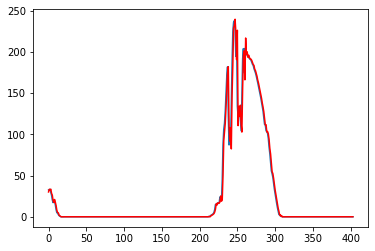

In [57]:
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()